In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import functorch
import matplotlib.pyplot as plt

import os
from datetime import datetime
import time

import Double_Pendulum.Lumped_Mass.robot_parameters as robot_parameters
import Double_Pendulum.Lumped_Mass.transforms as transforms
import Double_Pendulum.Lumped_Mass.dynamics as dynamics
import Learning.loss_terms as loss_terms
#import Plotting.plotters_h1h2 as plotters_h1h2
import Learning.training_data as training_data
import Plotting.theta_visualiser as theta_visualizer

from functools import partial

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
rp = robot_parameters.LUMPED_PARAMETERS
print(rp)

cuda
{'l1': 3.1, 'l2': 2.0, 'm': 3.0, 'g': 9.81, 'xa': 5.0, 'ya': 2.0}


In [3]:
def masked_points(q1_split, angle_margin = 0):

    """
    Returns a set of [q1, q2] points based on "q1_split" limits on q1 and an angle_margin on q2.
    If angle_margin = 0, only returns points for which q1 < q2 < q1 + pi.
    With angle_margin > 0, reduces points to prevent those close to non-singular mapping
    """   


    # Retrieve training points
    points = training_data.points.to(device)
    
    valid_mask = ((points[:,1] >= points[:,0] + angle_margin) & 
                  (points[:,1] <= points[:,0] + torch.pi -angle_margin) & 
                  (points[:,0] >= q1_split[0]) &
                  (points[:,0] <= q1_split[1]))
    
    points = points[valid_mask]
    points = points[0:3000]

    if points.size(0) < 3000:
        print("Warning: Only", points.size(0), "points in dataset.")

    return(points)

In [4]:
def points_plotter(points):
    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0].cpu().numpy(), points[:, 1].cpu().numpy(), alpha=0.6, edgecolors='k', s=20)
    plt.title('Scatter Plot of q1 vs q2')
    plt.xlabel('q1')
    plt.ylabel('q2')
    plt.xlim(-torch.pi, torch.pi)
    plt.ylim(-torch.pi, torch.pi)
    plt.grid(True)
    plt.show()

In [5]:


def make_dataset(points):

    """
    Compute mass- and input matrix of all training points to reduce load in training.
    Returns TensorDataset of (q, M_q, A_q). 
    """

    data_pairs = []
    for point in points:
        Mq_point, _, _ = dynamics.dynamical_matrices(rp, point, point)
        Aq_point = dynamics.input_matrix(rp, point)
        data_pairs.append((point, Mq_point, Aq_point))

    points_tensor = torch.stack([pair[0] for pair in data_pairs])           # Tensor of all points
    mass_matrices_tensor = torch.stack([pair[1] for pair in data_pairs])   # Tensor of all mass matrices
    input_matrices_tensor = torch.stack([pair[2] for pair in data_pairs])  # Tensor of all input matrices

    # Create TensorDataset
    dataset = TensorDataset(points_tensor, mass_matrices_tensor, input_matrices_tensor)
    return(dataset)


In [6]:
def make_dataloaders(dataset, batch_size = 512, train_part = 0.7):

    train_size = int(train_part * len(dataset))
    val_size = len(dataset) - train_size

    # Create TensorDataset for both training and testing sets
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    # Create the DataLoader for both training and testing sets
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return(train_dataloader, val_dataloader)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, rp):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 2)
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Softplus(),
            nn.Linear(16, 16),
            nn.Softplus(),
            nn.Linear(16, 2)
        )
        
        self.rp = rp
        
    def encoder_theta_1_ana(self, q):
        theta_1 = transforms.analytic_theta_1(self.rp, q).unsqueeze(0)
        return theta_1, theta_1
    
    #This function is not used in the forward pass, but is useful for comparing learned to analytic theta_2
    def encoder_theta_2_ana(self, q):
        theta_2 = transforms.analytic_theta_2(self.rp, q).unsqueeze(0)
        return theta_2, theta_2
    
    def theta_ana(self, q):
        theta_1_ana, _ = torch.vmap(self.encoder_theta_1_ana)(q)
        theta_2_ana, _ = torch.vmap(self.encoder_theta_2_ana)(q)
        theta_ana = torch.cat((theta_1_ana, theta_2_ana), dim=1)
        return theta_ana

    def encoder_nn(self, q):
        theta = self.encoder(q)
        return theta, theta
    
    def decoder_nn(self, theta):
        q_hat = self.decoder(theta)
        return q_hat, q_hat
    
    def forward(self, q):
        
        J_h_1_ana, theta_1_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_1_ana, has_aux=True))(q)
        J_h_2_ana, theta_2_ana = torch.vmap(torch.func.jacfwd(self.encoder_theta_2_ana, has_aux=True))(q)
        J_h_ana = torch.cat((J_h_1_ana, J_h_2_ana), dim=1).float()
        
        
        J_h, theta = torch.vmap(torch.func.jacfwd(self.encoder_nn, has_aux=True))(q)

        J_h_dec, q_hat = torch.vmap(torch.func.jacfwd(self.decoder_nn, has_aux=True))(theta)

        return(theta, J_h, q_hat, J_h_dec, J_h_ana)

In [8]:
#%%time
#%matplotlib widget




In [9]:
import torch.nn.functional as F

def loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec):
    l_recon = F.mse_loss(q, q_hat, reduction="sum")

    """ If you pick J_h_inv to be the decoder Jacobian"""
    J_h_trans = torch.transpose(J_h, 1, 2)
    J_h_inv = J_h_dec
    J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)

    M_th = J_h_inv_trans @ M_q @ J_h_inv  # Batch-wise diagonalization

    
    # Enforce inertial decoupling
    #l_off_dia = torch.mean((M_th - torch.diagonal(M_th, dim1=1, dim2=2))**2)  # Penalize off-diagonal terms
    l_off_dia = torch.mean((M_th[:, 0, 1])**2)
    l_dia = torch.mean(-(torch.log(M_th[:, 0, 0])/(M_th[:, 0, 0]**0.8) + 
                        torch.log(M_th[:, 1, 1])/(M_th[:, 0, 0]**0.8)))

    ## input decoupling loss
    A_th = J_h_inv_trans @ A_q
    l_input = torch.mean((A_th[:, 1]**2)) + torch.sum(((A_th[:, 0]-1)**2))


    l_input = 10 * l_input

    loss = l_recon + l_input + l_dia + l_off_dia
    loss_terms = torch.tensor([l_recon, l_input, l_dia, l_off_dia])

    return loss, loss_terms

In [10]:

#model.load_state_dict(torch.load(load_path, weights_only=True))





def AE_model(rp, device, lr, num_epochs, q1_split, model_nr, train_dataloader, val_dataloader, current_time):
   
    model = Autoencoder(rp).to(device)  # Move model to GPU
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#,  weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5 ** (1 / num_epochs))


    train_losses = []
    val_losses = []
    start_time = time.time()
    save_directory = os.path.join(os.getcwd(), "Models/Split_AEs")
    os.makedirs(save_directory, exist_ok=True)
    file_name = f"Lumped_Mass_{current_time}_{model_nr}.pth"
    file_path = os.path.join(save_directory, file_name)

    JSON = {"Model nr" : model_nr,
            "q1_low" : q1_split[0],
            "q1_high" : q1_split[1],
            "lr" : lr,
            "epochs" : num_epochs,
            "file_name" : file_name}

    for epoch in range(num_epochs):

        # Training phase
        model.train()
        train_loss = 0
        train_loss_terms = torch.zeros(4)
        for index, (q, M_q, A_q) in enumerate(train_dataloader):
            #batch_size = batch[0].shape[0]
            q = q.to(device)
            #q.requires_grad = True
            #q_d = batch[0].to(device)

            M_q = M_q.to(device)
            A_q = A_q.to(device)
            
            theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)  
            theta_ana = model.theta_ana(q)
                    
            loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_loss_terms += loss_terms
        train_loss /= len(train_dataloader.dataset)
        train_loss_terms /= len(train_dataloader.dataset)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0
        val_loss_terms = torch.zeros(4)
        with torch.no_grad():
            for index, (q, M_q, A_q) in enumerate(val_dataloader):
                q = q.to(device)
                M_q = M_q.to(device)
                A_q = A_q.to(device)

                theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
                theta_ana = model.theta_ana(q)

                loss, loss_terms = loss_fun(q, q_hat, M_q, A_q, J_h, J_h_dec)

                J_h_inv = torch.linalg.inv(J_h)
                J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
                M_th = J_h_inv_trans @ M_q @ J_h_inv 

                val_loss += loss.item()
                val_loss_terms += loss_terms
        val_loss /= len(val_dataloader.dataset)
        val_loss_terms /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        epoch_duration = time.time() - start_time
        scheduler.step()

        if epoch % 50 == 0:
            print(
                f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Duration: {epoch_duration:.2f} seconds'
                )

            print(
                f"recon: {val_loss_terms[0].item():.4f}, "
                f"input: {val_loss_terms[1].item():.4f}, "
                f"dia: {val_loss_terms[2].item():.4f}, "
                f"off_dia: {val_loss_terms[3].item():.4f}, "
            )
        
    return(model, train_losses, val_losses, file_path)


In [11]:
def save_model(model, file_path):
    torch.save(model.state_dict(), file_path)
    print(f"Model parameters saved to {file_path}")


In [12]:
def plot_loss(train_losses, val_losses):

    """
    Plots training and validation loss. 
    "ylim" and "yscale" should be enabled depending on the loss function.
    """

    plt.figure(figsize=(5, 3))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    #plt.ylim((-1, 40))
    plt.legend()
    plt.title("Training and Validation Loss over Epochs")
    plt.grid(True)
    #plt.yscale("log")
    plt.show()


In [13]:
import Plotting.plotters_simple as plotters_simple

def make_plot_dataloader(dataset):

    """
    Takes the training dataset and returns a dataloader of every 10th point
    to reduce visual clutter. 
    """

    points_tensor, mass_matrices_tensor, input_matrices_tensor = dataset.tensors
    
    plot_sampled = points_tensor[::10]
    mass_sampled = mass_matrices_tensor[::10]
    input_sampled = input_matrices_tensor[::10]

    plot_dataset = TensorDataset(plot_sampled, mass_sampled, input_sampled)
    plot_dataloader = DataLoader(plot_dataset, batch_size=len(plot_dataset), shuffle=False, num_workers=0)

    return(plot_dataloader)

In [14]:
def plot_model_performance(model, plot_dataloader):

    model.eval()
    with torch.no_grad():
        for (q, M_q, A_q) in plot_dataloader:
            q = q.to(device)
            M_q = M_q.to(device)
            A_q = A_q.to(device)

            theta, J_h, q_hat, J_h_dec, J_h_ana = model(q)
            theta_ana = model.theta_ana(q)
            J_h_trans = torch.transpose(J_h, 1, 2)
            J_h_inv = J_h_dec
            J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
            #J_h_inv = J_h_trans
            #J_h_inv_trans = J_h
            M_th = J_h_inv_trans @ M_q @ J_h_inv
            A_th = (J_h_inv_trans @ A_q).squeeze(-1)

            off_dia = M_th[:, 0, 1]
            diag_elements = M_th[:, [0, 1], [0, 1]]
            #diag_product = torch.sqrt(diag_elements[:, 0] * diag_elements[:, 1])# + 1e-8
            diag_product = diag_elements[:, 1]
            M_th_ratio = off_dia/diag_product

            J_ortho = J_h @ J_h_trans        
            J_h_identity = J_h @ J_h_inv  # Batch-wise multiplication
            l_J_inv = ((torch.eye(J_h_identity.size(-1), device=J_h_identity.device) - J_h_identity)**2).sum(dim=(1,2)) 
            l_J_ortho = ((torch.eye(J_h_identity.size(-1), device=J_h_identity.device) - J_ortho)**2).sum(dim=(1,2))

            
            #plotters_simple.plot_3d_double(q, theta_ana[:, 0], theta[:, 0], "h0", "analytical", "learned", "h0", device)
            #plotters_simple.plot_3d_double(q, theta_ana[:, 1], theta[:, 1], "h1", "analytical", "learned", "h1", device)

            #plotters_simple.plot_3d_double(q, J_h_ana[:, 0, 0], J_h[:, 0, 0], "J_h_00", "analytical", "learned", "J_h_00", device)
            #plotters_simple.plot_3d_double(q, J_h_ana[:, 0, 1], J_h[:, 0, 1], "J_h_01", "analytical", "learned", "J_h_01", device)
            #plotters_simple.plot_3d_double(q, J_h_ana[:, 1, 0], J_h[:, 1, 0], "J_h_10", "analytical", "learned", "J_h_10", device)
            #plotters_simple.plot_3d_double(q, J_h_ana[:, 1, 1], J_h[:, 1, 1], "J_h_11", "analytical", "learned", "J_h_11", device)

            plotters_simple.plot_3d_double(q, M_th_ratio, M_th_ratio, "Inertial decoupling", "capped", "full", "M_th_ratio", device, z_limits = (0, 1))

            plotters_simple.plot_3d_double(q, A_th[:, 0], A_th[:, 1], "Input decoupling", "A0", "A1", "A", device)

            #plotters_simple.plot_3d_double(q, l_J_ortho, l_J_inv, "Jacobian properties", "Orthogonality J_h", "J_h@J_h_inv - I", "J_h", device)
            
            #plotters_simple.plot_3d_double(q, M_th[:, 0, 0], M_th[:, 0, 1], "M_th", "00", "01", "M_th", device)
            #plotters_simple.plot_3d_double(q, M_th[:, 1, 0], M_th[:, 1, 1], "M_th", "10", "11", "M_th", device)


In [15]:
def theta_1_single(model, q):
    theta = model.encoder_nn(q)[0]
    return theta[:, 0].detach()
    
def theta_2_single(model, q):
    theta = model.encoder_nn(q)[0]
    return theta[:, 1].detach()
    
def q_hat_1_single(model, theta):
    q_hat = model.decoder_nn(theta)[0]
    return q_hat[:, 0].detach()
    
def q_hat_2_single(model, theta):
    q_hat = model.decoder_nn(theta)[0]
    return q_hat[:, 1].detach()

Epoch [1/1001], Training Loss: 16.6985, Validation Loss: 15.8865, Duration: 0.43 seconds
recon: 5.6835, input: 9.8245, dia: 0.3785, off_dia: 0.0000, 
Epoch [51/1001], Training Loss: 1.2589, Validation Loss: 1.1778, Duration: 6.95 seconds
recon: 0.1407, input: 1.0357, dia: -0.0011, off_dia: 0.0025, 
Epoch [101/1001], Training Loss: 0.7651, Validation Loss: 0.7233, Duration: 14.01 seconds
recon: 0.0863, input: 0.6351, dia: -0.0013, off_dia: 0.0032, 
Epoch [151/1001], Training Loss: 0.5203, Validation Loss: 0.5123, Duration: 20.95 seconds
recon: 0.0593, input: 0.4522, dia: -0.0012, off_dia: 0.0020, 
Epoch [201/1001], Training Loss: 0.3110, Validation Loss: 0.3159, Duration: 27.78 seconds
recon: 0.0393, input: 0.2761, dia: -0.0011, off_dia: 0.0016, 
Epoch [251/1001], Training Loss: 0.1632, Validation Loss: 0.1688, Duration: 34.79 seconds
recon: 0.0321, input: 0.1359, dia: -0.0014, off_dia: 0.0022, 
Epoch [301/1001], Training Loss: 0.1164, Validation Loss: 0.1217, Duration: 41.71 seconds
re

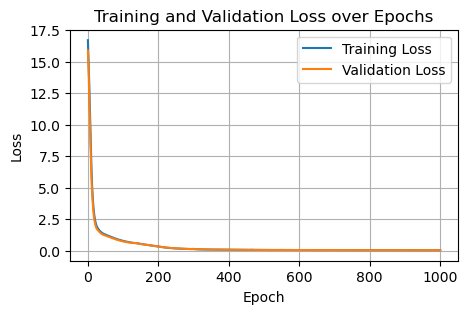

Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Split_AEs/Lumped_Mass_202501171553_0.pth
Epoch [1/1001], Training Loss: 11.0139, Validation Loss: 10.2903, Duration: 0.13 seconds
recon: 2.3521, input: 7.8060, dia: 0.1322, off_dia: 0.0000, 
Epoch [51/1001], Training Loss: 1.5210, Validation Loss: 1.5031, Duration: 7.05 seconds
recon: 0.9345, input: 0.5668, dia: 0.0003, off_dia: 0.0015, 
Epoch [101/1001], Training Loss: 0.3781, Validation Loss: 0.3627, Duration: 14.13 seconds
recon: 0.1212, input: 0.2326, dia: -0.0012, off_dia: 0.0101, 
Epoch [151/1001], Training Loss: 0.2661, Validation Loss: 0.2622, Duration: 20.90 seconds
recon: 0.0960, input: 0.1645, dia: -0.0005, off_dia: 0.0023, 
Epoch [201/1001], Training Loss: 0.1737, Validation Loss: 0.1741, Duration: 27.87 seconds
recon: 0.0540, input: 0.1197, dia: -0.0001, off_dia: 0.0005, 
Epoch [251/1001], Training Loss: 0.0982, Validation Loss: 0.1008, Duration: 34.82 seconds
recon: 0.0382, input: 0.

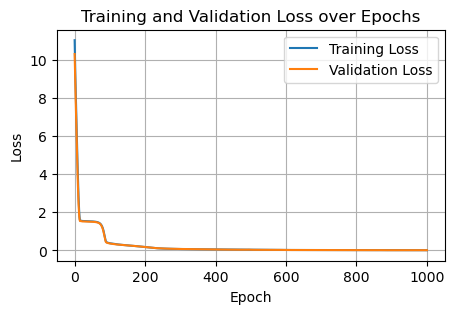

Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Split_AEs/Lumped_Mass_202501171553_1.pth
Epoch [1/1001], Training Loss: 14.7696, Validation Loss: 14.2208, Duration: 0.16 seconds
recon: 2.6306, input: 11.1145, dia: 0.4757, off_dia: 0.0000, 
Epoch [51/1001], Training Loss: 1.9602, Validation Loss: 1.6578, Duration: 8.67 seconds
recon: 0.3774, input: 1.2783, dia: 0.0019, off_dia: 0.0002, 
Epoch [101/1001], Training Loss: 0.9852, Validation Loss: 0.8386, Duration: 17.06 seconds
recon: 0.1779, input: 0.6588, dia: 0.0018, off_dia: 0.0000, 
Epoch [151/1001], Training Loss: 0.7338, Validation Loss: 0.5984, Duration: 25.62 seconds
recon: 0.1690, input: 0.4276, dia: 0.0000, off_dia: 0.0018, 
Epoch [201/1001], Training Loss: 0.5399, Validation Loss: 0.4396, Duration: 34.21 seconds
recon: 0.0985, input: 0.3377, dia: -0.0010, off_dia: 0.0043, 
Epoch [251/1001], Training Loss: 0.4117, Validation Loss: 0.3473, Duration: 42.70 seconds
recon: 0.0321, input: 0.3

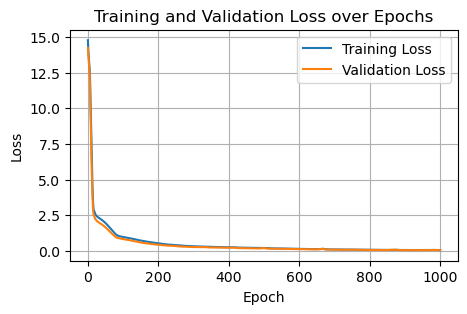

Model parameters saved to /home/kian/Documents/Thesis/ICS_fork/ics-pa-sv/Kian_code/Models/Split_AEs/Lumped_Mass_202501171553_2.pth


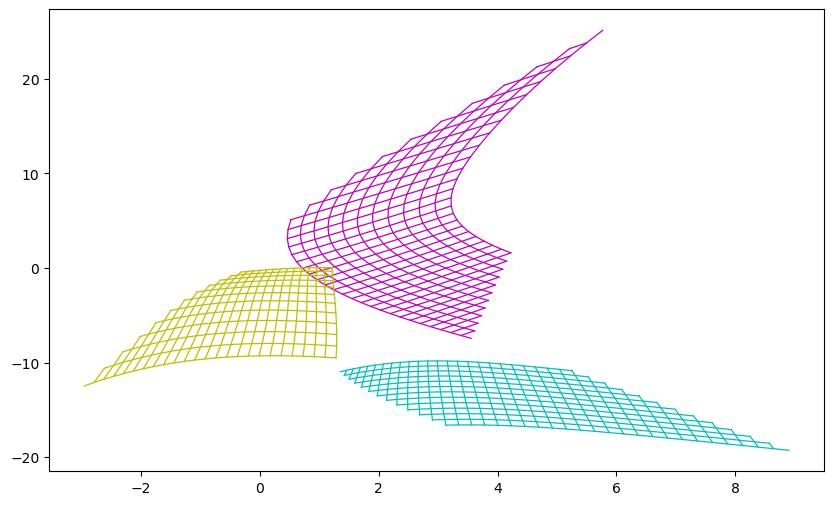

In [16]:
q1_splits = [(-torch.pi, -torch.pi/2),
             (-torch.pi/2, 0),
             (0, torch.pi/2)]

angle_margin = torch.pi/10

batch_size = 512
train_part = 0.7

rp = robot_parameters.LUMPED_PARAMETERS
num_epochs = 1001
lr = 1e-3


plt.ion()
mapping_functions_list = []
model_list = []
train_losses_list = []
val_losses_list = []
file_path_list = []


current_time = datetime.now().strftime("%Y%m%d%H%M")

for model_nr, q1_split in enumerate(q1_splits):
    points = masked_points(q1_split, angle_margin)
    #points_plotter(points)
    dataset = make_dataset(points)
    (train_dataloader, val_dataloader) = make_dataloaders(dataset=dataset, batch_size=batch_size, train_part=train_part)

    outputs = []
    model, train_losses, val_losses, file_path = AE_model(rp, device, lr, num_epochs, q1_split, model_nr, train_dataloader, 
                                                          val_dataloader, current_time)
    
    plot_loss(train_losses, val_losses)
    mapping_functions = (partial(theta_1_single,model), 
                         partial(theta_2_single,model), 
                         partial(q_hat_1_single,model), 
                         partial(q_hat_2_single,model))
    
    mapping_functions_list.append(mapping_functions)
    model_list.append(model)
    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    file_path_list.append(file_path)
    
    save_model(model, file_path)

th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, device=device, 
                                            mapping_functions_list=mapping_functions_list, mask_splits=q1_splits)
th_plotter.make_figure("theta_learned_patchwork_test_image.png")
th_plotter.make_animation("theta_learned_patchwork_test.mp4", duration = 4, fps = 20, stride = 1)

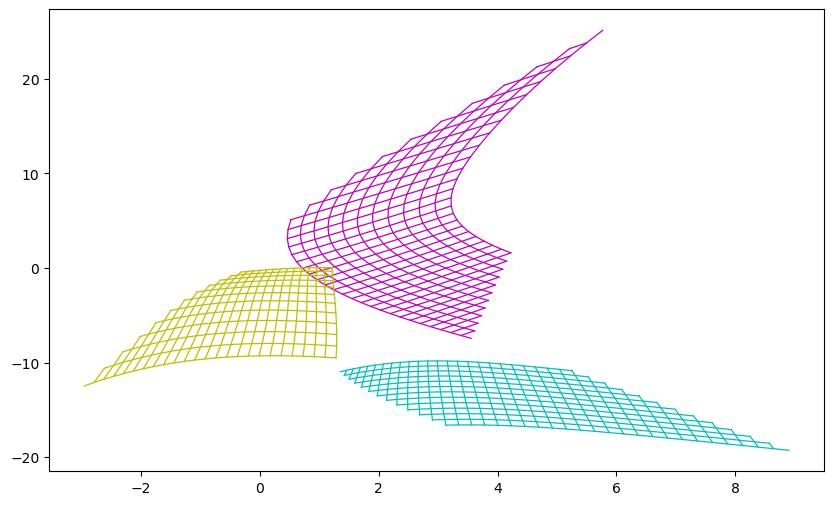

In [17]:
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, device=device, 
                                            mapping_functions_list=mapping_functions_list, mask_splits=q1_splits)
th_plotter.make_figure("theta_learned_patchwork_test_image.png")

In [18]:
mapping_functions = (partial(torch.vmap(transforms.analytic_theta_1, in_dims=(None, 0)), rp), 
                     partial(torch.vmap(transforms.analytic_theta_2, in_dims=(None, 0)), rp))
th_plotter = theta_visualizer.theta_plotter(rp=rp, n_lines=50, mapping_functions=mapping_functions)
th_plotter.make_figure("theta_subset_5_2_image.png")
th_plotter.make_animation("theta_subset_5_2.mp4", duration = 4, fps = 20, stride = 1)

TypeError: theta_plotter.__init__() got an unexpected keyword argument 'mapping_functions'

## OLD LOSS FUNCTION

In [ ]:
### OLD LOSS FUNCTION

def loss_fun(q, q_hat, m_matrix, input_matrix, J_h, J_h_dec):
    l_recon = F.mse_loss(q, q_hat, reduction="sum")

    """ If you pick J_h_inv to be the inverse/transpose of Jh"""
    #J_h_inv = torch.transpose(J_h, 1, 2)
    #J_h_trans = J_h_inv
    #J_h_inv_trans = J_h

    """ If you pick J_h_inv to be the decoder Jacobian"""
    J_h_trans = torch.transpose(J_h, 1, 2)
    J_h_inv = J_h_dec
    J_h_inv_trans = torch.transpose(J_h_inv, 1, 2)
    

    # Orthogonality ensures that the transformation does not "stretch" too much
    # NOTE:, if using J_h_inv = J_h^T, J_ortho and J_h_identity are the _same_ thing
    J_ortho = J_h @ J_h_trans
    J_ortho_inv = J_h_inv @ J_h_inv_trans
    
    J_h_identity = J_h @ J_h_inv  # Batch-wise multiplication
    identity_target = torch.eye(J_h_identity.size(-1), device=J_h_identity.device)


    # Enforce that decoder Jacobian is the inverse of the encoder Jacobian
    ## USE ONLY WHEN J_h_inv == J_h_dec
    l_J_inv = torch.sum((identity_target - J_h_identity)**2)  # Frobenius norm
    l_J_ortho_inv = torch.sum((identity_target - J_ortho_inv)**2)  # Frobenius norm\n",

    # Enforce that the Jacobian is orthogonal
    l_J_ortho = torch.sum((identity_target - J_ortho)**2)  # Frobenius norm

    diag_matrix = J_h_inv_trans @ m_matrix @ J_h_inv  # Batch-wise diagonalization
    """
    # Enforce inertial decoupling (diagonal loss)
    off_dia = diag_matrix[:, 0, 1]
    trace = torch.einsum('bii->b', diag_matrix) 
    M_th_ratio = off_dia/trace
    l_diag = nn.MSELoss()(M_th_ratio, torch.zeros((M_th_ratio.size())).to(device))
    """
    
    # Enforce inertial decoupling
    ## Slight concern is that this sends all values of M_th to 0. Hopefully l_J_ortho avoids this
    dia_mask = torch.eye(2).unsqueeze(0).repeat(diag_matrix.size(0), 1, 1)
    l_off_dia = torch.sum(diag_matrix**2) - torch.sum(torch.diagonal(diag_matrix, dim1=1, dim2=2)**2)  # Penalize off-diagonal terms
    #l_off_dia = torch.sum((diag_matrix[:, 0, 1])**2)
    l_dia = torch.sum(-(torch.log(diag_matrix[:, 0, 0])/(diag_matrix[:, 0, 0]**0.8) + 
                        torch.log(diag_matrix[:, 1, 1])/(diag_matrix[:, 0, 0]**0.8)))
    #l_dia = 0

    ## input decoupling loss
    input_x = J_h_inv_trans @ input_matrix
    l_input = torch.sum((input_x[:, 1]**2)) + torch.sum(((input_x[:, 0]-1)**2))



    l_J_inv = 0
    l_J_ortho = 0 # 0.1 * l_J_ortho
    l_J_ortho_inv = 0 # 0.1 * l_J_ortho_inv
    l_input = 10 * l_input

    loss = l_recon + l_dia + l_off_dia + l_input #+ l_J_inv #+ l_J_ortho + l_J_ortho_inv
    loss_terms = torch.tensor([l_recon, l_input, l_dia, l_off_dia, l_J_ortho, l_J_inv, l_J_ortho_inv])

    return loss, loss_terms